In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("C:\\Users\\Hasan\\Desktop\\data science folder\\Fraud_Data_Final.csv")

# Convert timestamps
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

# Check class distribution
print(df["class"].value_counts(normalize=True) * 100)


class
0    90.635423
1     9.364577
Name: proportion, dtype: float64


In [2]:
def rule_based_fraud_detection(df):
    df["rule_fraud"] = 0  # Default: Not fraud

    # Use 'purchase_value' 
    df.loc[df["purchase_value"] > 10000, "rule_fraud"] = 1

    # Rule 2: Transactions made between 12 AM - 4 AM
    df["hour"] = df["purchase_time"].dt.hour
    df.loc[df["hour"].between(0, 4), "rule_fraud"] = 1

    # Rule 3: Multiple transactions within 10 minutes by the same user
    df["time_diff"] = df.groupby("user_id")["purchase_time"].diff().dt.seconds
    df.loc[df["time_diff"] < 600, "rule_fraud"] = 1

    return df

df = rule_based_fraud_detection(df)
print(df[["purchase_value", "rule_fraud"]].head())  # Check the rule-based fraud column


   purchase_value  rule_fraud
0              34           1
1              16           1
2              15           0
3              44           0
4              39           0


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
import shap
import matplotlib.pyplot as plt

# ✅ Convert timestamps
df["purchase_time"] = pd.to_datetime(df["purchase_time"])
df["signup_time"] = pd.to_datetime(df["signup_time"])

# ✅ Drop unnecessary columns
df = df.drop(columns=["signup_time", "device_id"])

# ✅ Feature Engineering: Extract useful time-based features
df["purchase_hour"] = df["purchase_time"].dt.hour
df["purchase_day"] = df["purchase_time"].dt.day
df["purchase_weekday"] = df["purchase_time"].dt.weekday

# ✅ Remove original timestamp columns (they are now encoded in time-based features)
df = df.drop(columns=["purchase_time"])

# ✅ Convert categorical features to numerical using One-Hot Encoding
df = pd.get_dummies(df, columns=["source", "browser", "sex"], drop_first=True)

# ✅ Check if all columns are numeric
print(df.dtypes)


c:\Users\Hasan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


user_id               int64
purchase_value        int64
age                   int64
ip_address            int64
class                 int64
rule_fraud            int64
hour                  int32
time_diff           float64
purchase_hour         int32
purchase_day          int32
purchase_weekday      int32
source_Direct          bool
source_SEO             bool
browser_FireFox        bool
browser_IE             bool
browser_Opera          bool
browser_Safari         bool
sex_M                  bool
dtype: object


In [4]:
def rule_based_fraud_detection(df):
    df["rule_fraud"] = 0  # Default: Not fraud

    # ✅ Rule 1: Transactions with high value (> $10,000)
    df.loc[df["purchase_value"] > 10000, "rule_fraud"] = 1

    # ✅ Rule 2: Transactions at unusual times (Midnight - 4 AM)
    df.loc[df["purchase_hour"].between(0, 4), "rule_fraud"] = 1

    # ✅ Rule 3: Multiple transactions by the same user within 10 minutes
    df["time_diff"] = df.groupby("user_id")["purchase_hour"].diff()
    df.loc[df["time_diff"] < 0.167, "rule_fraud"] = 1  # 10 minutes = 0.167 hours

    return df

# ✅ Apply the rule-based system
df = rule_based_fraud_detection(df)

# ✅ Check rule-based fraud cases
print(df[["rule_fraud"]].value_counts())


rule_fraud
0             119852
1              31260
Name: count, dtype: int64


In [5]:
# ✅ Define Features (`X`) and Target (`y`)
X = df.drop(columns=["class", "rule_fraud"])  # Use all features except labels
y = df["class"]  # Fraud (1) or Non-Fraud (0)

# ✅ Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ✅ Make Predictions
y_pred = model.predict(X_test)

# ✅ Evaluate Model Performance
print("🔹 Machine Learning Model Performance:")
print(classification_report(y_test, y_pred))


🔹 Machine Learning Model Performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27373
           1       1.00      0.54      0.70      2850

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



In [6]:
# ✅ Predict fraud probability using the trained ML model
df["ml_fraud_prob"] = model.predict_proba(X)[:, 1]

# ✅ Hybrid Fraud Detection: If either Rule-Based OR ML detects fraud, flag it
df["hybrid_fraud"] = ((df["rule_fraud"] == 1) | (df["ml_fraud_prob"] > 0.8)).astype(int)

# ✅ Compare results
print(df[["class", "rule_fraud", "ml_fraud_prob", "hybrid_fraud"]].head(10))


   class  rule_fraud  ml_fraud_prob  hybrid_fraud
0      0           1           0.08             1
1      0           1           0.03             1
2      1           0           0.97             1
3      0           0           0.01             0
4      0           0           0.02             0
5      0           0           0.03             0
6      0           1           0.03             1
7      0           0           0.02             0
8      0           0           0.04             0
9      0           0           0.03             0


<Figure size 1600x1200 with 0 Axes>

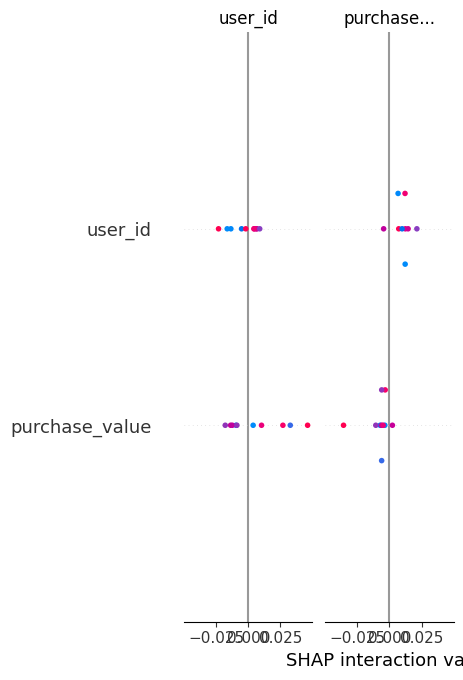

In [7]:
import shap
# ✅ Use SHAP to explain feature importance
explainer = shap.TreeExplainer(model)

# ✅ Select a small subset of test data for visualization
subset_X_test = X_test.iloc[:10]  

# ✅ Compute SHAP values
shap_values = explainer.shap_values(subset_X_test)

# ✅ Ensure SHAP values match feature matrix
if isinstance(shap_values, list):  # For classification models
    shap_values = shap_values[1]  # Extract fraud class SHAP values

plt.figure(figsize=(16, 12))  
# ✅ Generate SHAP summary plot
shap.summary_plot(shap_values, subset_X_test)


In [8]:
def evaluate_model(y_true, y_pred, name):
    print(f"\n🔹 {name} Model Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")

# ✅ Evaluate models
evaluate_model(df["class"], df["rule_fraud"], "Rule-Based System")
evaluate_model(df["class"], (df["ml_fraud_prob"] > 0.8).astype(int), "ML-Based System")
evaluate_model(df["class"], df["hybrid_fraud"], "Hybrid System")



🔹 Rule-Based System Model Performance:
Accuracy: 0.7367
Precision: 0.0900
Recall: 0.1987

🔹 ML-Based System Model Performance:
Accuracy: 0.9557
Precision: 1.0000
Recall: 0.5267

🔹 Hybrid System Model Performance:
Accuracy: 0.7767
Precision: 0.2374
Recall: 0.6257
